## Energy Innovation MCOE Compilation

- <a href=#setup>Setup</a>
- <a href=#data_out>Data Outputs</a>
    * <a href=#final-plant>Plant Level Output</a>
    * <a href=#final-unit>Unit Level Output</a>
    * <a href=#src-tbl>Source Table</a>
- <a href=#data_comp>Data Components</a>
    * <a href=#part1>Part 1: Basic Plant & Unit Information</a>
    * <a href=#part2>Part 2: Cost Data</a>
    * <a href=#part3>Part 3: Emissions & Public Health Data</a>
- <a href=#data_val>Data Validation</a>
    * <a href=#ferc-v-eia>FERC Form 1 vs. EIA</a>

-------------

## <a id='setup'>Setup</a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pudl
import sqlalchemy as sa
from ei_mcoe import *
import sys
import os
import matplotlib.pyplot as plt
import logging

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# basic setup for logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]
pd.options.display.max_columns = None

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

In [5]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine, freq='AS', rolling=True)

-------------

## <a id='data_out'>Data Outputs</a>

In [6]:
%%time
cems_df = get_cems(pudl_settings)

Getting CEMS data....this may take a sec.
CPU times: user 20.9 s, sys: 3.06 s, total: 23.9 s
Wall time: 2min 39s


### <a id='final-plant'>Plant Level Output</a>

In [18]:
%%time
plant = main(pudl_out, cems_df, 'plant-fuel', separate_nems_cols=True)

Prepping raw EIA data
Converting date to year
Calculating generator age
Eliminating retired plants
PUDL plant id's in from prep_raw_eia 10941.
PUDL plant id's in raw_eia_df 10941.
Converting date to year
Building Part 1 output
 - Checking EIA aggregation for plants with different qualitative data
checking for differences in: plant_name_eia
 - [52, 53, 54, 82, 122, 136, 211, 219, 236, 292, 336, 342, 351, 367, 386, 402, 409, 483, 507, 520, 592, 611, 613, 629, 652, 659, 736, 796, 812, 837, 965, 970, 990, 998, 1005, 1006, 1035, 1392, 1395, 1397, 1694, 1736, 1756, 1776, 1835, 1838, 1938, 2349, 2353, 2440, 3072, 3265, 3467, 4041, 4223, 4303, 4458, 4657, 4870, 5893, 6267, 6875, 7397, 9746, 9927, 10240, 10828] have internal differences in plant_name_eia
checking for differences in: state
 - [53, 82, 211, 837, 4303, 4458, 5893] have internal differences in state
checking for differences in: city
 - [52, 53, 82, 211, 219, 386, 507, 611, 613, 736, 837, 1006, 1035, 2349, 3072, 3265, 3384, 4223, 43

In [19]:
#test_segment(plant)

### <a id='final-unit'>Unit Level Output</a>

In [20]:
# unit = main(pudl_out, cems_df, 'unit-fuel')

In [21]:
#t = test_segment(unit)
#year_selector(t, [2012, 2013])

### <a id='src-tbl'>Source Table</a>

In [22]:
#generate_source_df()

-------------------------

## <a id='data_comp'>Data Components</a>

### <a id='part1'>Part 1: Plant & Unit Level Data</a>
EIA-860 and EIA-923 generator-level data is aggregated by either plant or unit and subdivided by broad fuel type (coal, gas, oil, waste). 
[`Age`] is calculated by finding the weighted average (capacity as weight) of the generators in a given aggregation. 
[`Heat Rate`] is also calculated by weighted average (this time with net generation as weight). 
[`MW Nameplate Capacity`] and [`Annual Electricity Net Generation MWh`] at a given level of aggregation are calculated by summing generator-level data. 

For purely qualitative information (just plant name and location) add [`drop_calcs=True`] to the parameters.

### <a id='part2'>Part 2: Cost Data</a>

Cost and generation data from EIA-860, EIA-923, and FERC Form 1 are subdivided by plant and broad fuel type. The fuel-type breakdown for FERC Form 1 plants is determined by the EIA fuel breakdown for plants of the same PUDL Plant Code. For missing fixed and variable costs from 2018, we've input data from NEMS as a subsitutde. MCOE is calculated using data from the following sources:

##### MCOE Variable Origins (as named in original database)
- Fuel cost = **EIA-923**: [`total_fuel_cost`]
- MW Capacity = **EIA-860**: [`capacity_mw`]
- Net MWh Generated = **EIA-923**: [`net_generation_mwh`]
- Variable O&M = **FERC Form 1**: [`opex_production_total`] - [`opex_fuel`]
- Fixed O&M = **FERC Form 1**: [`capex_total`]

##### Data Flags
[`Significant Heat Rate Discrepancy`] - a field indicating whether a plant fuel type contains units that have outlier heatrates. If a unit is more than one standard deviation away from the mean value for units of its same fuel type rate, the field will appear [`True`].

[`Fixed/Variable O&M used NEMS?`] - a field indicating whether the given row used FERC Form 1 cost data or NEMS cost data. If NEMS were used, the field will appear [`True`].

[`Count`].

### <a id='part3'>Part 3: Emissions & Public Health Data</a>

CEMS, or Continuous Emission Monitoring Systems, provide detailed information about gas, particulate matter and other pollutants that emanate from various point sources. Here, CEMS data on co2, so2, and nox emissions from generation units is combined with EIA plant data at the plant and unit level, separated by fuel type. 

Data on PM2.5 emissions comes from Argonne National Laboratory's GREET Model. The model's Electricity Generation Module table 2.1 contains PM2.5 emissions data in g/kwh at the grandularity of NERC region and technology type. The PM2.5 emissions data are mapped onto EIA and CEMS data by creating buckets of the same granularity.



--------------

## <a id='data_val'>Data Validation</a>

### <a id='ferc-v-eia'>FERC Form 1 vs. EIA</a>

The first test looks at the **validity of using EIA fuel percentage values to disaggregate FERC Form 1 data by fuel type.** 


The following hisograms compare the fuel fractions available in FERC Form 1 with the fuel fractions created by aggregating EIA data by plant and fuel type. The cost factors used in the calculation of MCOE rely on FERC Form 1 fixed and operating cost data broken down by plant and fuel type based on EIA fuel breakdown. To ensure that there is a degree of similarity between the percent breakdown of EIA fuel break down and FERC Form 1 breakdown, this histogram depicts the EIA percent / FERC Form 1 percent. FERC Form 1 has two fuel breakdowns, by MMBtu and by cost. The graph to the left divides EIA percents by FERC Form 1 MMBtu fuel fractions and on the right by cost fractions. The closer the value to 1, the more acurate the comparison.

In [24]:
# plot_fuel_pct_check(merge_ferc1_eia_fuel_pcts(pudl_out))

As we know, FERC Form 1 and EIA data don't always match up properly. The following graphs depict **the difference in FERC Form 1 and EIA-860/923 reporting on the these particular values:** [`capacity_mw`], [`opex_fuel`], [`total_mmbtu`], [`net_generation_mwh`], [`capacity_factor`], [`heat_rate_mmbtu_mwh`], [`fuel_cost_per_mwh`], [`fuel_cost_per_mmbtu`], used in the calculation of MCOE.

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


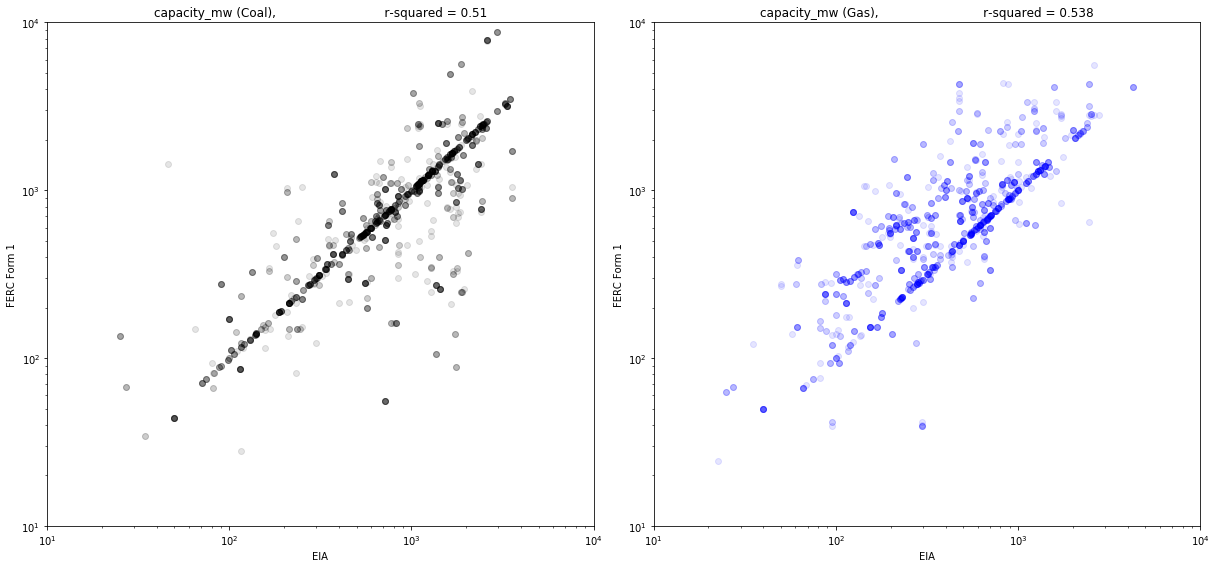

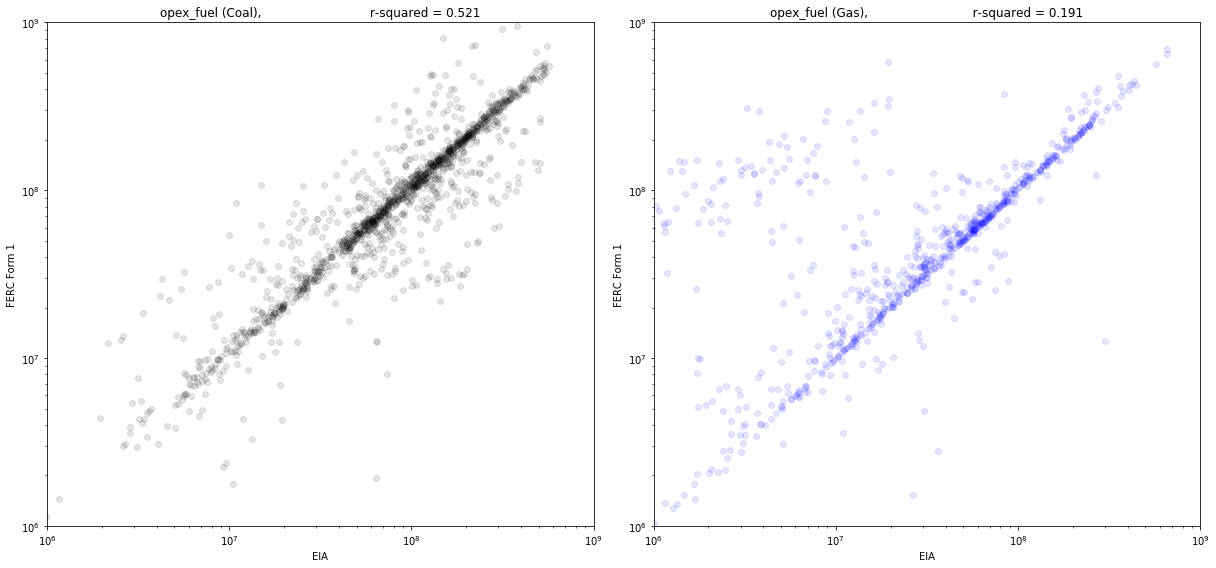

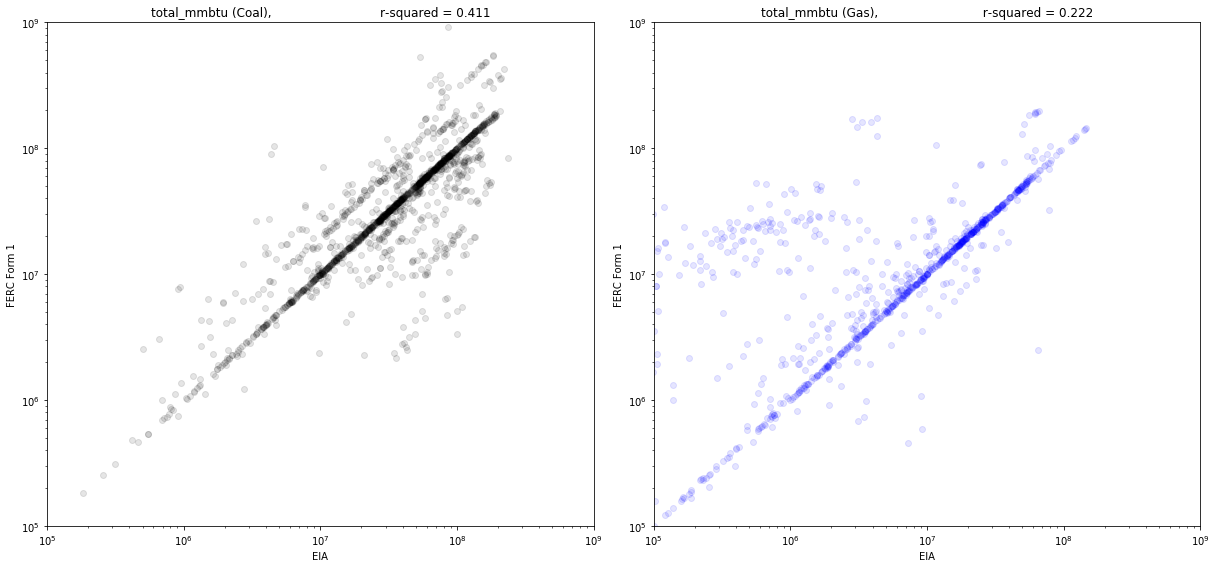

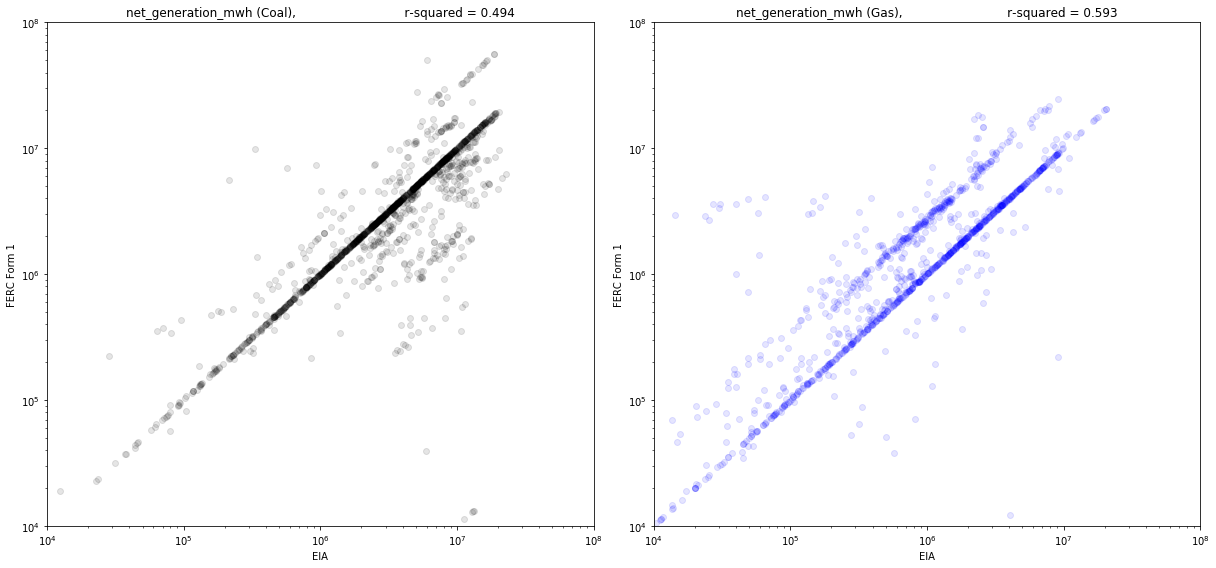

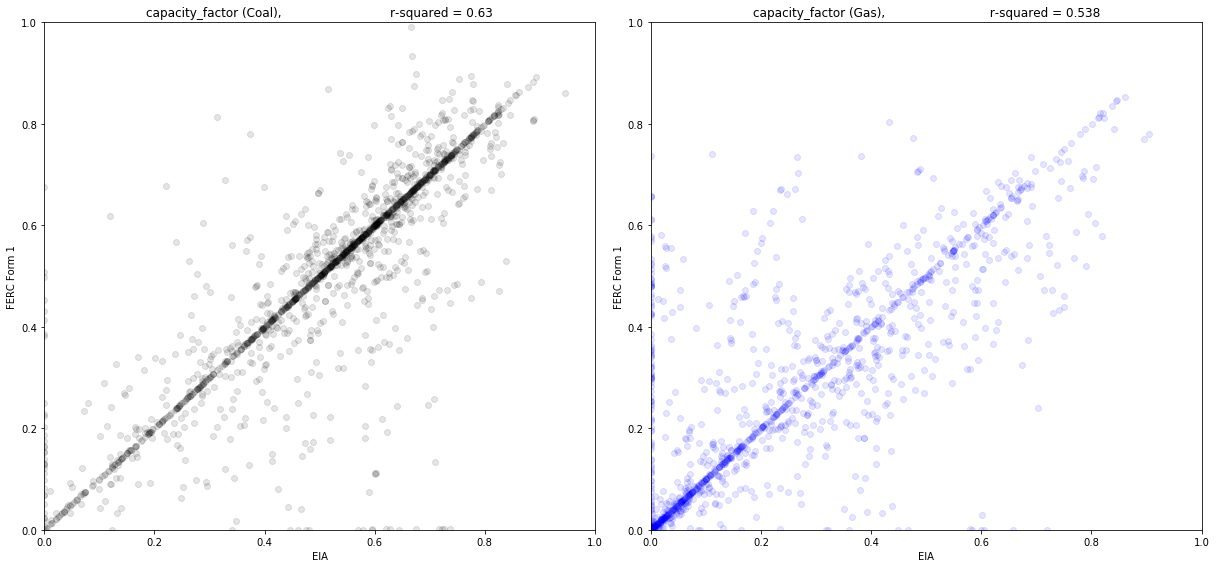

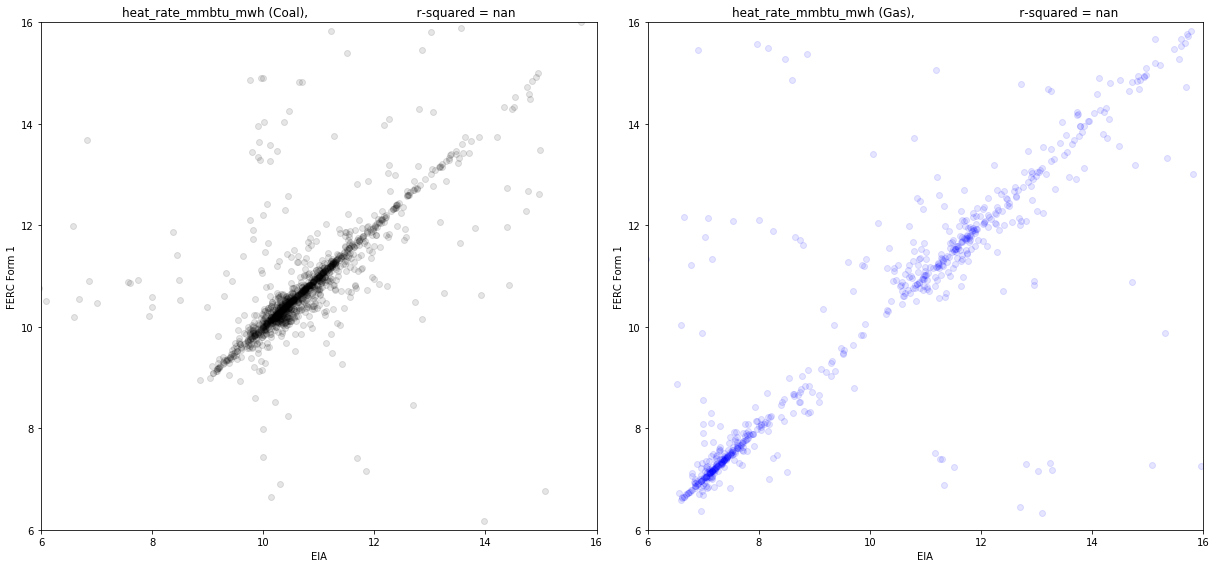

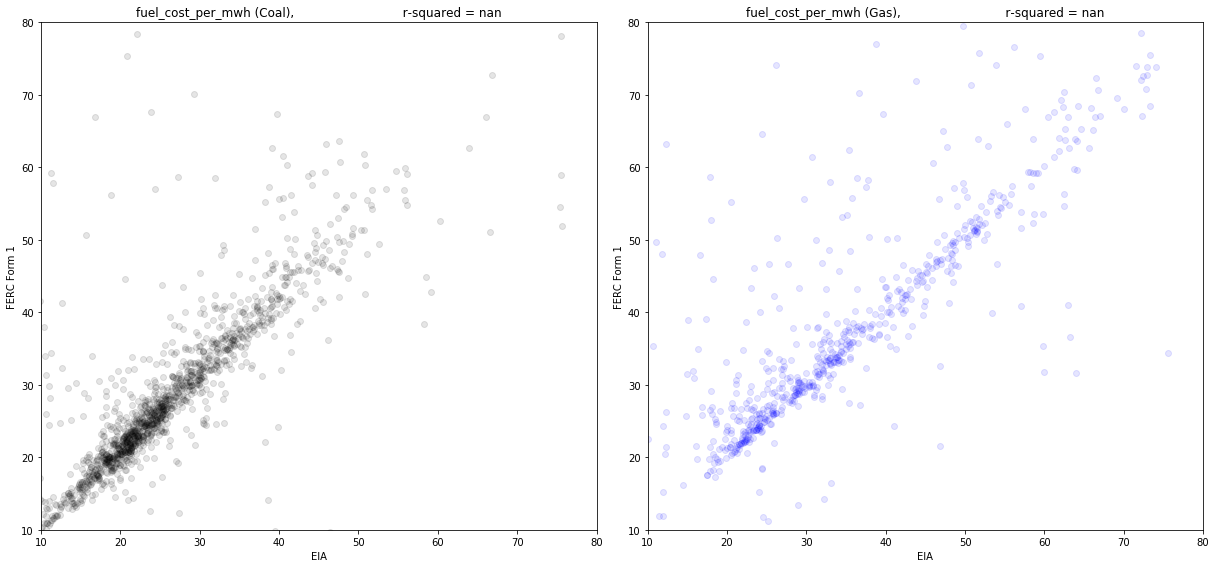

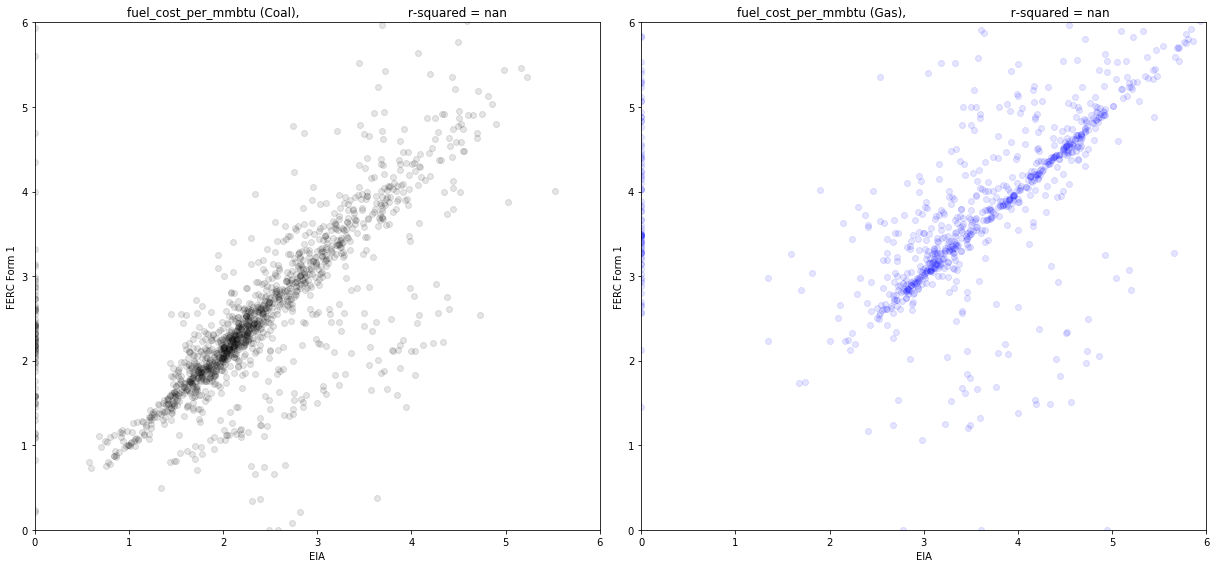

In [25]:
plot_eia_v_ferc(pudl_out)

### <a id='heatrate'>Heat Rate Comparison</a>

Prepping raw EIA data
Converting date to year
Calculating generator age
Eliminating retired plants
PUDL plant id's in from prep_raw_eia 10941.
 - Comparing heat rates internally
Building Part 1 output
 - Checking EIA aggregation for plants with different qualitative data
checking for differences in: plant_name_eia
checking for differences in: state
checking for differences in: city
checking for differences in: county
checking for differences in: latitude
checking for differences in: longitude
 - Calculating weighted average for generator_age_years
 - Calculating weighted average for heat_rate_mmbtu_mwh
PUDL plant id's in agg_wa_df 1314.
Finished compiling Part 1 unit-fuel level data


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


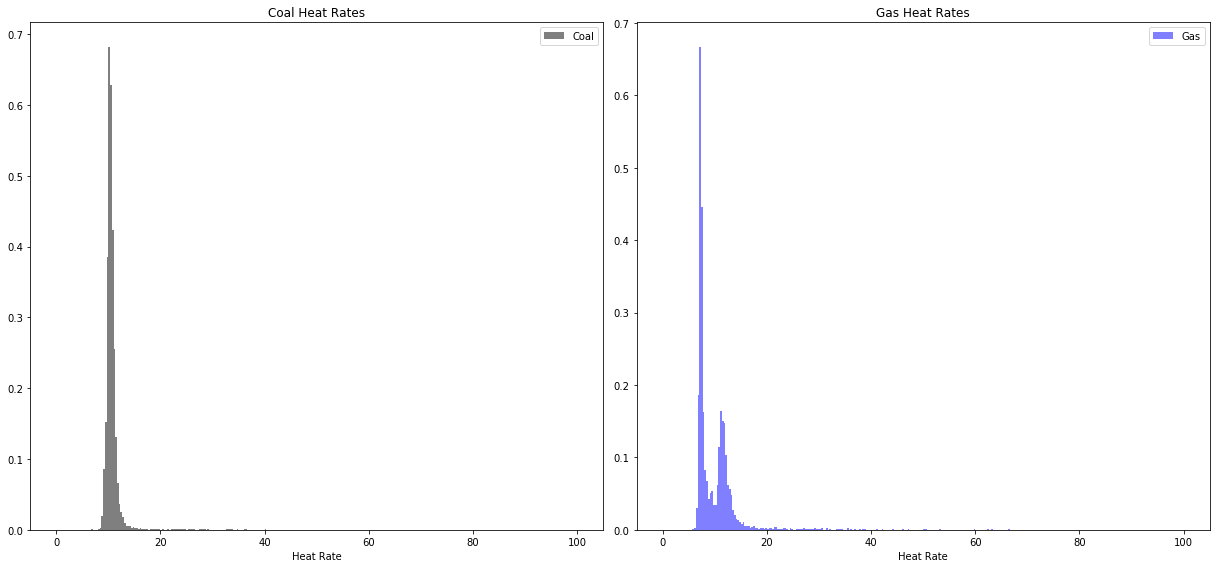

In [26]:
plot_heat_rate(pudl_out)

### Check the MCOE Compilation

this is a check to see the general shape of the fixed and variable O&M of the PUDL data is similar to NEMS

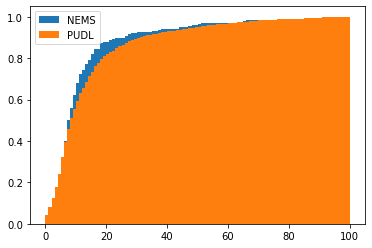

In [27]:
plant_non_nems = plant[~plant.fix_var_is_NEMS]
plt.hist((plant_non_nems.fix_var_om_mwh_18_nems), density=True, cumulative=True, 
         range=(0,100), label='NEMS',
         bins=100);

plt.hist(plant_non_nems.fix_var_om_mwh, density=True, cumulative=True, 
         range=(0,100), label='PUDL',
         bins=100);

plt.legend()
plt.show()

The following graph, we're simply plotting the components of MCOE against MCOE.
This should be just a straight line... which it appears to be, so yay.
The `mcoe` column has the least amount of records in it because it requires having both fuel cost data from EIA and fixed and variable cost data from FERC or NEMS.

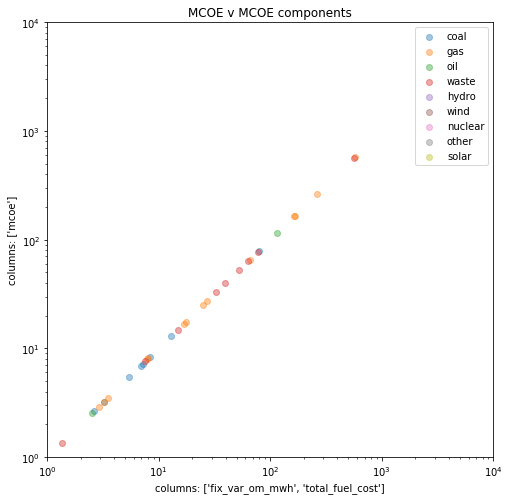

In [28]:
plot_mcoe_vs_nems(plant, 
                  x_cols=['mcoe'], y_cols=['fix_var_om_mwh','total_fuel_cost'], 
                  log=True, 
                  x_lim=(1,1e4), y_lim=(1,1e4),
                  alt_title='MCOE v MCOE components'
                 );

Now we are getting into comparing the components of MCOE. First let's compare the fixed and variable dollars per MWh.
Here are the plots

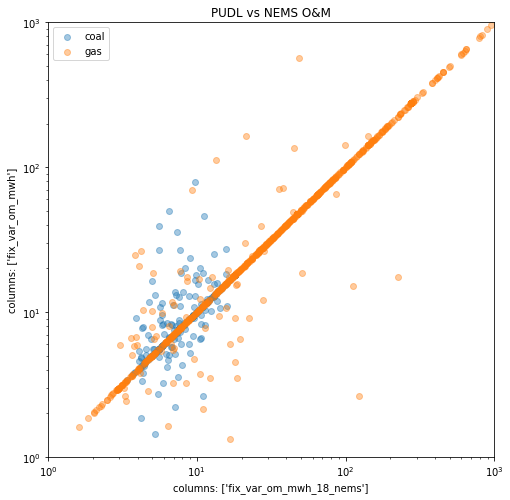

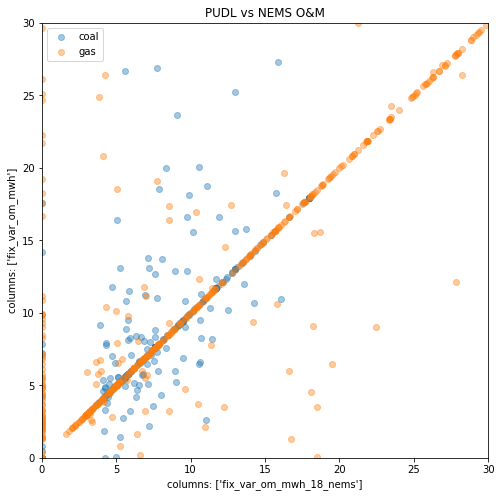

In [29]:
plot_mcoe_vs_nems(plant, 
                  x_cols=['fix_var_om_mwh'], y_cols=['fix_var_om_mwh_18_nems'], 
                  log=True, 
                  x_lim=(1,1e3), y_lim=(1,1e3),
                  fuels=['coal','gas']
                 );
plot_mcoe_vs_nems(plant, 
                  x_cols=['fix_var_om_mwh'], y_cols=['fix_var_om_mwh_18_nems'], 
                  log=False, 
                  x_lim=(0,30), y_lim=(0,30),
                  fuels=['coal','gas']
                 );

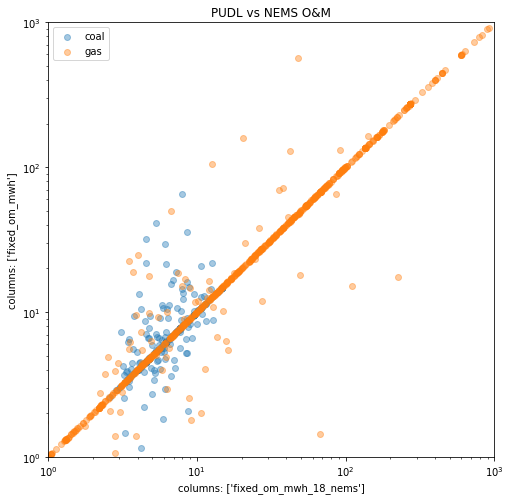

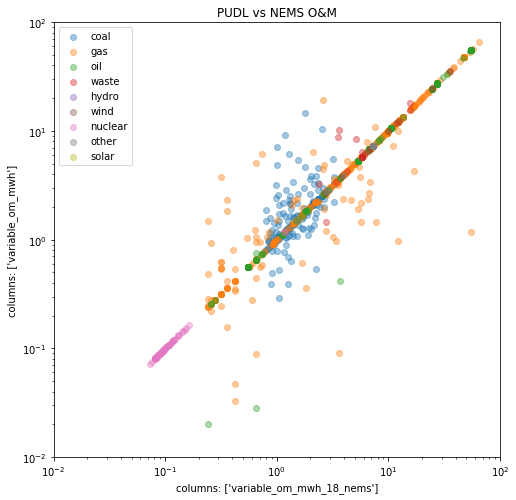

In [30]:
plot_mcoe_vs_nems(plant, 
                  x_cols=['fixed_om_mwh'], y_cols=['fixed_om_mwh_18_nems'], 
                  log=True, 
                  x_lim=(1,1e3),
                  y_lim=(1,1e3), 
                  fuels=['coal','gas']
                 );
plot_mcoe_vs_nems(plant, 
                  x_cols=['variable_om_mwh'], y_cols=['variable_om_mwh_18_nems'], 
                  log=True, 
                  x_lim=(.01,1e2),
                  y_lim=(.01,1e2)
                 );

There are the total fixed and variable dollar amounts. They look quite reasonable against NEMS totals.

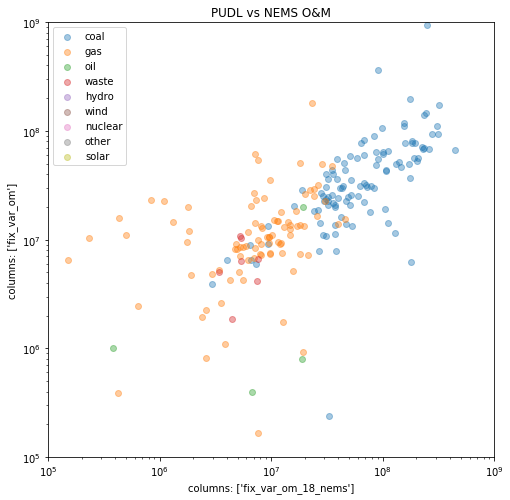

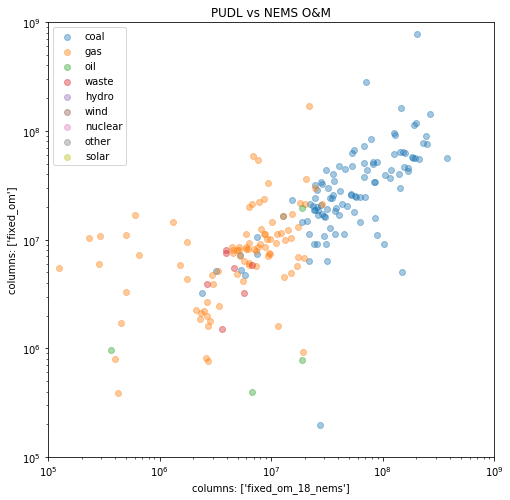

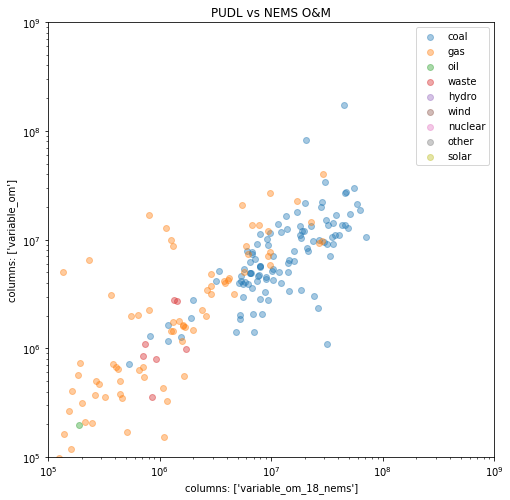

In [31]:
plot_mcoe_vs_nems(plant, 
                  x_cols=['fix_var_om'], y_cols=['fix_var_om_18_nems'], 
                  log=True, 
                  x_lim=(1e5,1e9),
                  y_lim=(1e5,1e9)
                 );
plot_mcoe_vs_nems(plant, 
                  x_cols=['fixed_om'], y_cols=['fixed_om_18_nems'], 
                  log=True, 
                  x_lim=(1e5,1e9),
                  y_lim=(1e5,1e9)
                 );
plot_mcoe_vs_nems(plant, 
                  x_cols=['variable_om'], y_cols=['variable_om_18_nems'], 
                  log=True, 
                  x_lim=(1e5,1e9),
                  y_lim=(1e5,1e9)
                 );

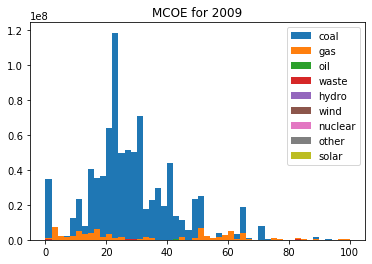

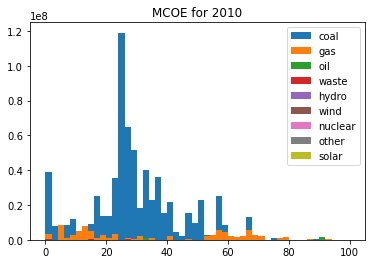

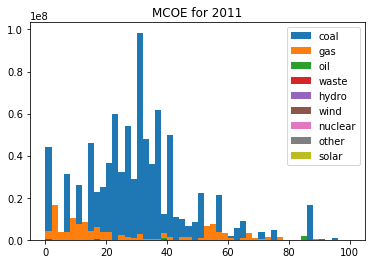

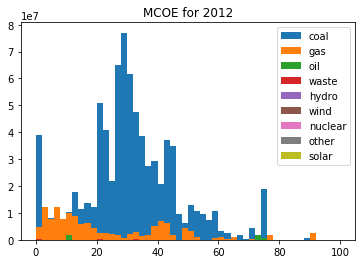

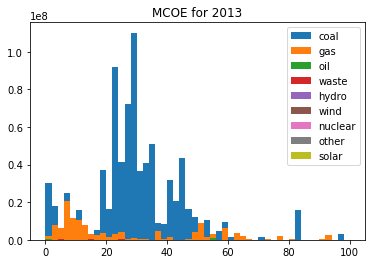

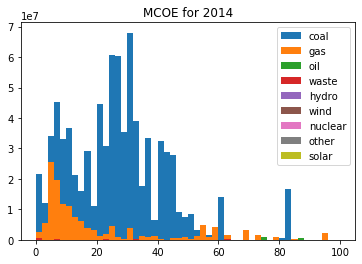

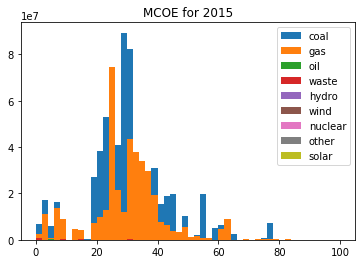

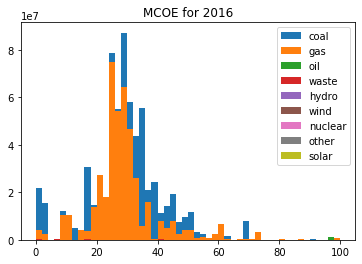

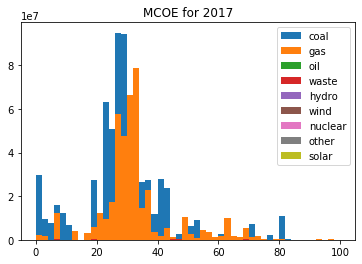

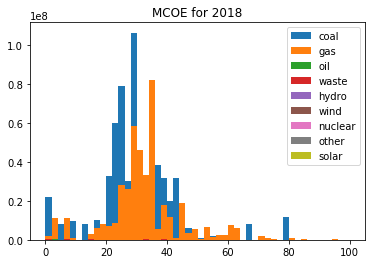

In [32]:
for year in plant.report_year.unique():
    for fuel in plant.fuel_type_code_pudl.unique():
        df = plant[(plant.fuel_type_code_pudl == fuel)
                       & (plant.report_year == year)
                      ]
        plt.hist(df.mcoe,
                 range=(0,100), 
                 bins=50, 
                 weights=df.net_generation_mwh,
                 label=f'{fuel}'
                );
    plt.legend()
    plt.title(f'MCOE for {year}')
    plt.show()
    

 - Calculating weighted average for fixed_om_mwh_18_nems
 - Calculating weighted average for variable_om_mwh_18_nems
 - Calculating weighted average for fix_var_om_mwh_18_nems


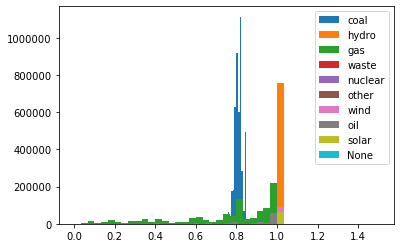

In [33]:
# this is a brief exploration of the split between fixed and variable costs from NEMS.
# there are clear patterns/differences between coal and gas.
# right now, we aren't using fuel type averages to break out fixed and variable costs
# but we could for the records which don't have associated NEMS data

nems = prep_nems(pudl_out)
fuel_tpyes= nems.fuel_type_code_pudl.unique()
for fuel_type in fuel_tpyes:
    df = nems[nems.fuel_type_code_pudl == fuel_type]
    plt.hist(df.fixed_v_total_ratio,
             weights=df.capacity_mw, label=f'{fuel_type}',
             bins=30
            )
plt.legend()
plt.show()

In [34]:
# this is here just to be able to look at a sampling of the plant output
plant[(plant.fixed_om_mwh.notnull())
       & (plant.fuel_type_code_pudl.isin(['coal','gas']))
       & (~plant.fix_var_is_NEMS)
       & (plant.variable_om_mwh_18_nems.notnull())
      ][
    ['mcoe', 'fuel_cost_mwh_eia923', 'fix_var_om_mwh', 'fix_var_om_mwh_18_nems',
     'variable_om_mwh', 'fixed_om_mwh', 'fixed_om_mwh2',
     'variable_om_mwh_18_nems','fixed_om_mwh_18_nems',
     'fuel_type_code_pudl',
     'fix_var_is_NEMS','plant_id_pudl'
    ]].round(1).sample(10)

,mcoe,fuel_cost_mwh_eia923,fix_var_om_mwh,fix_var_om_mwh_18_nems,variable_om_mwh,fixed_om_mwh,fixed_om_mwh2,variable_om_mwh_18_nems,fixed_om_mwh_18_nems,fuel_type_code_pudl,fix_var_is_NEMS,plant_id_pudl
5714,43.3,32.5,10.8,5.6,2.2,8.7,8.7,1.1,4.5,coal,False,144
19023,46.0,30.7,15.2,111.7,0.1,15.1,15.1,0.7,111.1,gas,False,491
14560,34.9,32.5,2.5,3.4,1.9,0.5,0.5,2.6,0.7,gas,False,369
15948,24.2,10.5,13.8,7.1,2.5,11.2,11.2,1.3,5.8,coal,False,409
17870,85.3,46.1,39.2,27.0,1.0,38.3,38.3,0.7,26.3,gas,False,461
1538,31.1,27.6,3.5,12.2,1.0,2.5,2.5,3.4,8.8,gas,False,39
12396,NaN,-714.7,-335.5,172.2,-28.4,-307.0,-307.0,18.3,153.9,gas,False,314
7950,39.2,28.5,10.6,15.8,0.4,10.2,10.2,0.7,15.1,gas,False,202
19659,49.2,24.0,25.2,13.0,4.6,20.7,20.7,2.4,10.7,coal,False,509
12038,31.1,19.1,12.0,13.6,2.4,9.6,9.6,2.7,10.9,coal,False,305


In [35]:
# quick exploration of 
plant_18 = plant[plant.report_year == 2018]
logger.info(f'all 2018 records:    {len(plant_18)}')
logger.info(f'2018 records w/ferc: {len(plant_18[plant_18.fix_var_om_mwh.notnull()])}')
logger.info(f'2018 records w/nems: {len(plant_18[plant_18.fix_var_om_mwh_18_nems.notnull()])}')
logger.info(f'2018 records w/eia:  {len(plant_18[plant_18.total_fuel_cost.notnull()])}')

all 2018 records:    48243
2018 records w/ferc: 5257
2018 records w/nems: 5180
2018 records w/eia:  10889


In [36]:
# this is an exploration of which plant_id_pudl's exist in NEMS vs EIA.
# there are a chunk of plants that only show up in NEMS, which is relatively odd.
# the code here up until `nems_merge_df` is straight from the module
# .... and it takes a minute to run.
raw_eia_df = prep_raw_eia(pudl_out)
eia_plant_fuel_df = prep_plant_fuel_data_eia(raw_eia_df)
ferc1_plant_df = prep_plant_fuel_data_ferc1(pudl_out)
eia_pct_df = compile_fuel_pcts_eia(raw_eia_df)
ferc1_plant_fuel_df = disaggregate_ferc1(eia_pct_df, ferc1_plant_df)
eia_ferc1_merge_df = (
    merge_ferc1_eia_mcoe_factors(eia_plant_fuel_df, ferc1_plant_fuel_df))

nems_merge_df = (
    pd.merge(eia_ferc1_merge_df, prep_nems(pudl_out),
             on=input_dict['merge_cols_nems'], how='outer',
             suffixes=("", "_nems"), indicator=True)
)

merge_year = nems_merge_df[nems_merge_df.report_year == 2018]
left = merge_year[merge_year._merge == 'left_only']
right = merge_year[merge_year._merge == 'right_only']
both = merge_year[merge_year._merge == 'both']

logger.info(f"EIA-only records:  {len(left)}")
logger.info(f"NEMS-only records: {len(right)}")
logger.info(f"Records in both:   {len(both)}")

Prepping raw EIA data
Converting date to year
Calculating generator age
Eliminating retired plants
PUDL plant id's in from prep_raw_eia 10941.
 - Building eia table broken down by plant and fuel type
PUDL plant id's in raw_ferc1_df 779.
 - Building FERC table broken down by plant
PUDL plant id's in ferc1_plant_df 779.
 - Readying EIA fuel pct data to merge with FERC
 - Building eia table broken down by plant and fuel type
 -- Calculating eia fuel type percentages
Turning eia fuel percent values for net_generation_mwh into columns
Turning eia fuel percent values for capacity_mw into columns
 - Merging FERC Form 1 data with EIA percent data
 -- Building FERC table broken down by plant and fuel type
PUDL plant id's in ferc1_pct_df 11115.
 -- Melting FERC pct data back to row values
PUDL plant id's in opex_melt_df 11115.
 - Merging FERC and EIA mcoe data on plant and fuel type
 - Calculating weighted average for fixed_om_mwh_18_nems
 - Calculating weighted average for variable_om_mwh_18_ne